# Basics fundamentals of Workflow

The goal of deep learning is to take some data from the past, build an algorithm (like a neural network) to discover patterns in it and use the discoverd patterns to predict what will come in. 

1. Data 2. Build 3. Train 4. Infer 5. Save 

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1'

Create some data. Straight line to start

In [5]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = (weight * X) + bias

X[:10], y[:10], X.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 torch.Size([50, 1]))

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

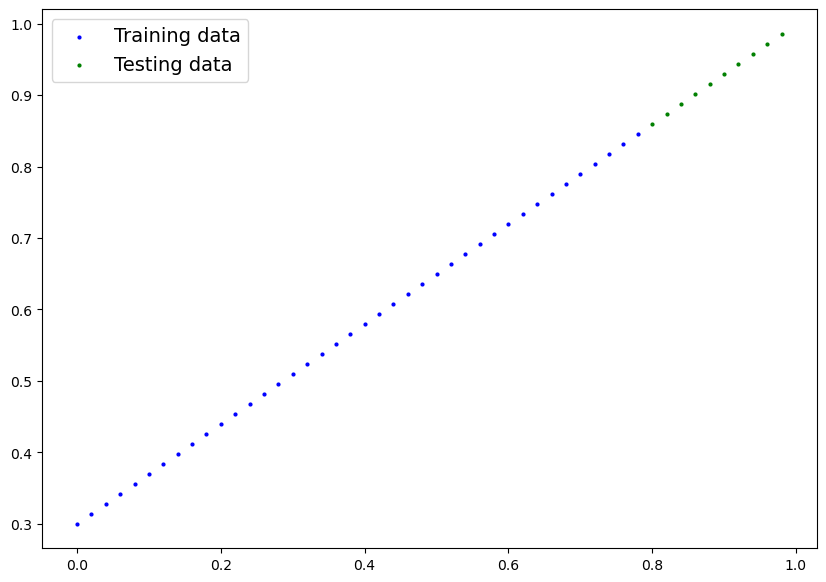

In [7]:
plot_predictions()

In [11]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): 
    # Almost everything in PyTorch is a nn.Module 
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, 
        # Start with random weights (this will get adjusted as the model learns)
        dtype=torch.float), # PyTorch usually has float32 by default
        requires_grad=True) # Update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1,dtype=torch.float), requires_grad=True) 
        # Start with random bias (this will get adjusted as the model learns)
        

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        # "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # Linear regression formula (y = m*x + b)

In [15]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# Make predictions with model

with torch.inference_mode(): 
    y_preds = model_0(X_test)

In [19]:
# Check the predictions

print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


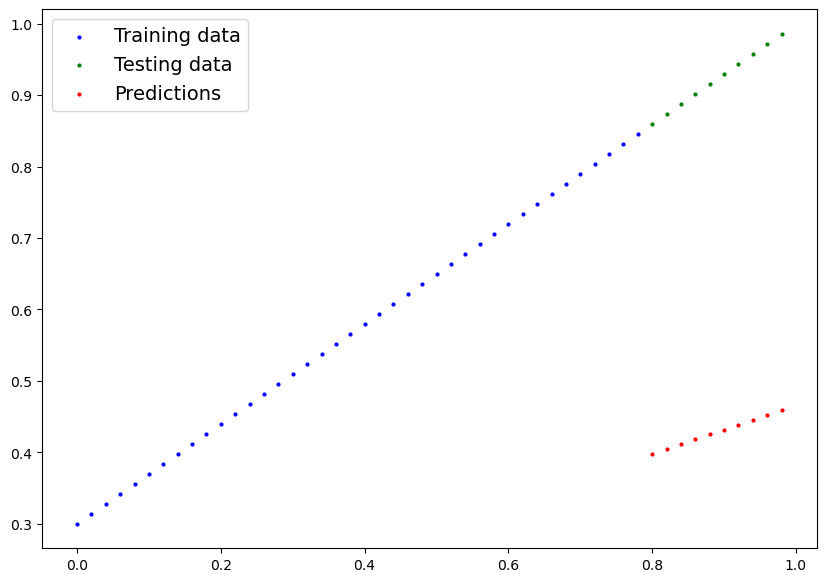

In [20]:
plot_predictions(predictions=y_preds)

This terrible match is expected since we are just using random parameter values to make predictions. We will now introduce loss function and optimizer to do better. 

In [21]:
# Create the loss function

loss_fn = nn.L1Loss() # MAE loss is same as L1Loss
# Remember L2 loss is Euclidean one (?) 

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) 
# learning rate (how much the optimizer should change parameters at each step, 
# higher is more (i.e., less stable))

In [22]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    
    
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)

    # 2. Calculate the loss (how different are our models predictions to the reality)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()
    # Backpropagation on loss function

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) 
     # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out status updates 
        
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788740023970604 | MAE Test Loss: 0.06473556160926819 


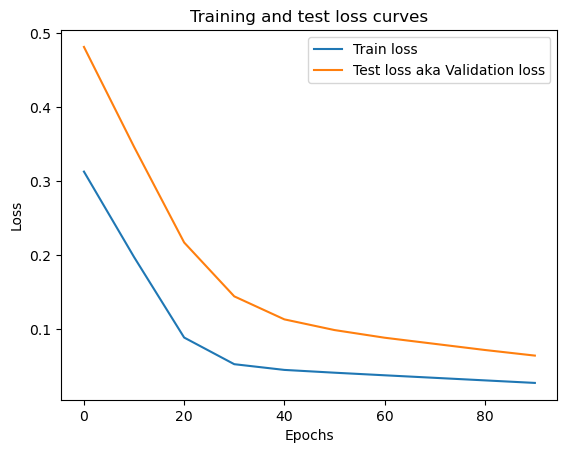

In [24]:
# Now plot the loss curves 

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss aka Validation loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [25]:
# How close did we get?

# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


There are three things to remember when making predictions (also called performing inference) 
with a PyTorch model

1. Set the model in evaluation mode (model.eval()).
2. Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [26]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

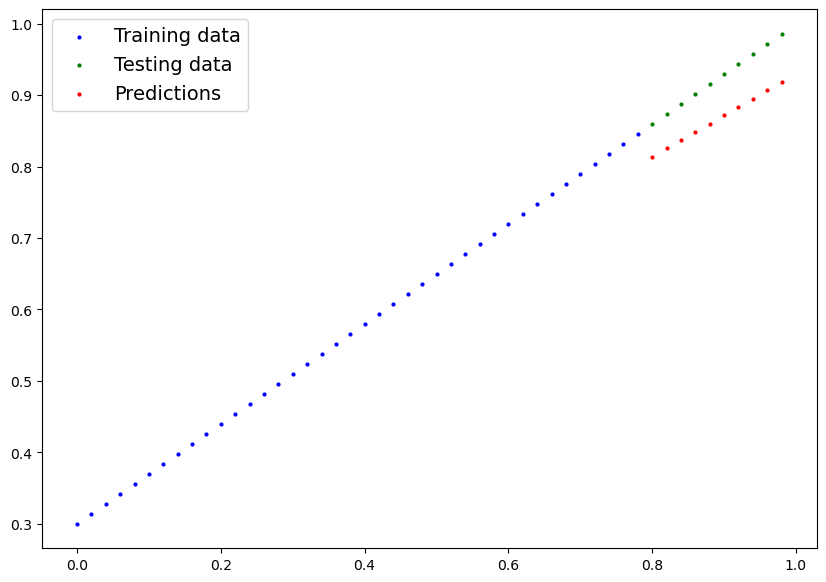

In [27]:
plot_predictions(predictions=y_preds)

In [28]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # Only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [29]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>